### Action item:
SEMPRE I RAPPORTI
1. fit legge in l a tau fisso per captare la dipendenza in l (t fiduciale, quello dell'ultimo paper di planck pag 19) (0 <l < 30 o 50)
2. fit legge in t a l del picco (circa l=5,6,7,8)
3. plot f(l)*g(t) 
4. dare più dati (affinare t) e cercare un'espressione unica c_ee(l,t) per l anche più grande di 50
5. cercare una smooth transition function in l che passi dal regime t^2 a e^(-2t) (magari dopo)

Farlo per EE , poi per TE

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor

In [202]:
def accuracy(data, model):
    if len(data) != len(model):
        print('ERROR: array must have the same length!')
        return
    
    l = len(data)
    total_error = 0
    
    for i in range(l):
        error = abs((data[i] - model[i]) / data[i])
        total_error += error
    
    avg_error = total_error / l
    accuracy_percentage = 100 * (1 - avg_error)
    
    return accuracy_percentage

In [203]:
model = PySRRegressor()

In [204]:
cl_raw = pd.read_csv('CL_20_50.csv')
tau_real = 0.0561
t_reio = np.round(np.linspace(0.0261, 0.1261, 20, endpoint=True),4)
index = np.abs(t_reio - tau_real).argmin()
t_reio[index] = tau_real
cl = cl_raw[(cl_raw['tau'] == tau_real)]

ell = cl_raw['ell'].values
ee = cl_raw['EE'].values
te = cl_raw['TE'].values
tt = cl_raw['TT'].values
tau = cl_raw['tau'].values

a = len(t_reio)
b = len(ell)
alpha = int(b/a)

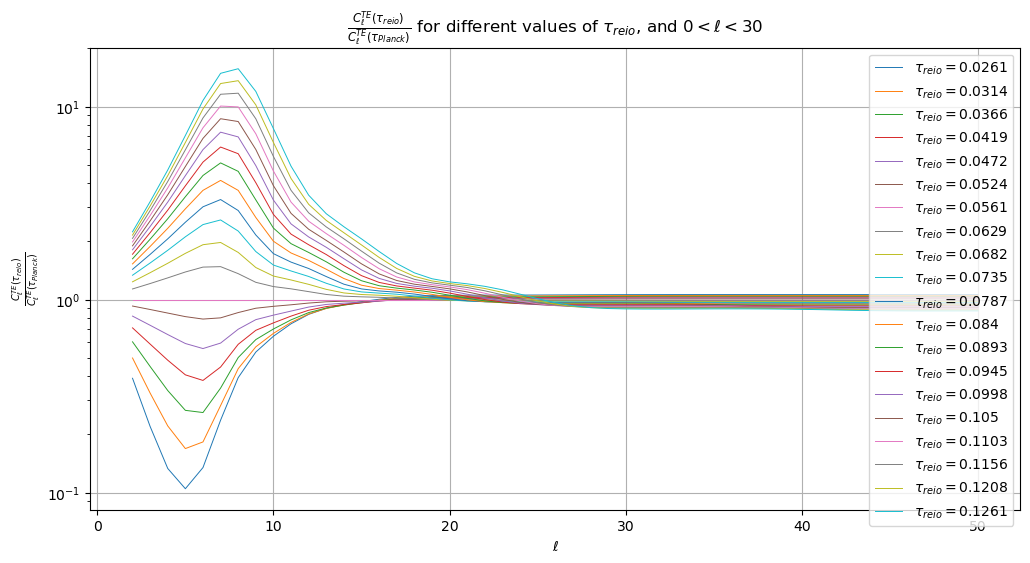

In [205]:
plt.figure(figsize=(12, 6))
ee_ratio = []
for i in range (a):
    l = ell[(i * alpha):(i + 1)*alpha]
    y = ee[(i * alpha):(i + 1)*alpha]/cl['EE'][0:alpha]
    ee_ratio.append(y)
    string = r'$\tau_{reio}=$' + str(round(t_reio[i], 4))
    plt.semilogy(l,y, label=string, lw=0.7)
    plt.legend()
plt.xlabel('$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$')
plt.title(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$ for different values of $\tau_{reio}$, and $0<\ell<30}$')
plt.grid(True)
plt.show()  

In [206]:
len(ee_ratio[19])

49

In [207]:
l = ell[0:alpha]
ratio_used = ee_ratio[19]
Cl = pd.DataFrame({'ell':l,'EE_max/EE_planck':ratio_used})
Cl.to_csv('Ratio(l).csv', index=False) 

we sort the arrays to use $\tau$ as variable and $\ell$ fixed

In [208]:
ratio_arr = np.concatenate(ee_ratio)
x_t = []
x_l = []
y_ratio = []

for i in range (alpha):
    for j in range (a):
        index = int(i+j*alpha)
        x_t.append(tau[index])
        x_l.append(ell[index])
        y_ratio.append(ratio_arr[index]) 

In [209]:
df = pd.DataFrame({'tau':x_t,'ell':x_l, 'EE/EE_planck':y_ratio})
cl_sort = df[(df['ell'] == 5)]
cl_sort.to_csv('Ratio(t)-l5.csv', index=False)

----
## Graphs for $f(\ell)$
----

model 1:
$$1.09 e^{e^{\sin{\left(\log{\left(\frac{0.598}{\left(0.797 \ell + 0.797 \cos{\left(0.467 \ell \right)} + 1\right)^{2.27}} \right)} \right)}}} - 0.741$$

Checking if ratio1-ee-1509.pkl exists...
Loading model from ratio1-ee-1509.pkl
The accuracy of this model is 90.51


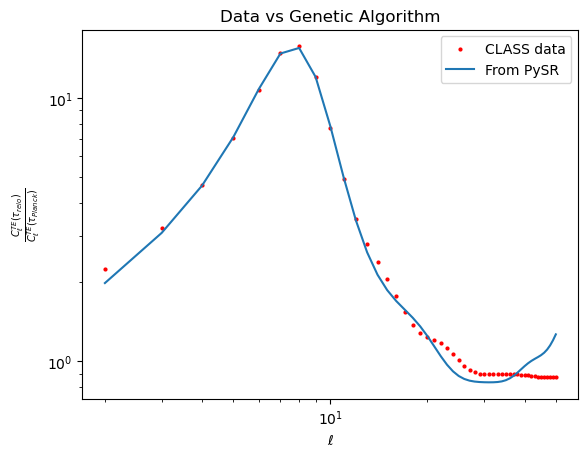

In [210]:
mod = model.from_file('ratio1-ee-1509.pkl')
l = l.reshape(-1,1)
ratio_used = np.array(ratio_used)

print('The accuracy of this model is', round(accuracy(ratio_used,mod.predict(l)),2))

plt.scatter(l,ratio_used, label='CLASS data', s=4, color='r')
plt.loglog(l,mod.predict(l), label='From PySR')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$')
plt.title('Data vs Genetic Algorithm')
plt.legend()


model 2:
$$ \left(\left(\frac{18.9}{\ell}\right)^{\ell} + e^{\left(2.00 e^{- 0.0454 \ell}\right)^{\ell}}\right)^{0.195} $$

Checking if ratio2-ee-1509.pkl exists...
Loading model from ratio2-ee-1509.pkl
The accuracy of this model is 90.91


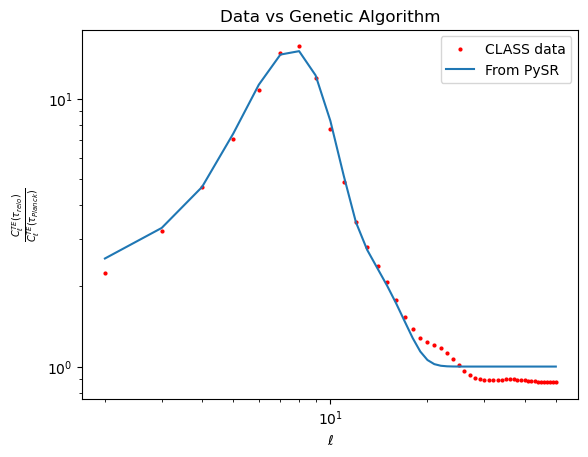

In [211]:
mod = model.from_file('ratio2-ee-1509.pkl')

print('The accuracy of this model is', round(accuracy(ratio_used,mod.predict(l)),2))

plt.scatter(l,ratio_used, label='CLASS data', s=4, color='r')
plt.loglog(l,mod.predict(l), label='From PySR')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$')
plt.title('Data vs Genetic Algorithm')
plt.legend()


$$ \tau^{0.267} + \left(15.6 \tau\right)^{- \tau + 4.72 e^{- \tau}} $$

Checking if hall_of_fame_2023-09-16_123109.154.pkl exists...
Loading model from hall_of_fame_2023-09-16_123109.154.pkl
The accuracy of this model is 98.94


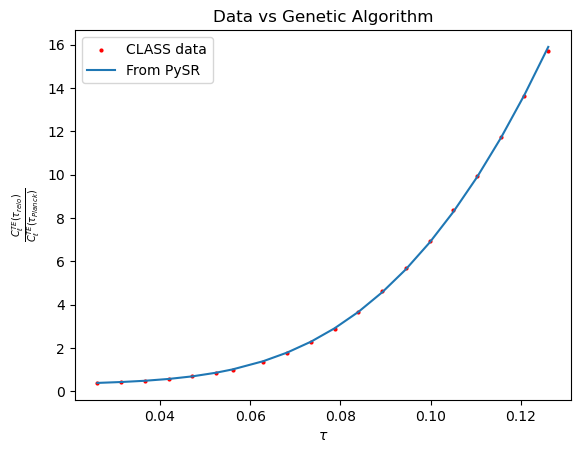

In [212]:
mod2 = model.from_file('hall_of_fame_2023-09-16_123109.154.pkl')

t = t_reio.reshape(-1,1)
ratio_tau = np.array(df[(df['ell'] == 8)]['EE/EE_planck'])
print('The accuracy of this model is', np.round(accuracy(ratio_tau,mod2.predict(t)),2))

plt.scatter(t_reio,ratio_tau, label='CLASS data', s=4, color='r')
plt.plot(t_reio,mod2.predict(t), label='From PySR')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$')
plt.title('Data vs Genetic Algorithm')
plt.legend()

$$\frac{1.25 \cdot 10^{5} \tau^{4.15}}{5.12 \cdot 10^{4} \tau^{5.92} + 1.29} + 0.384$$

Checking if hall_of_fame_2023-09-16_142645.495.pkl exists...
Loading model from hall_of_fame_2023-09-16_142645.495.pkl
The accuracy of this model is 98.77


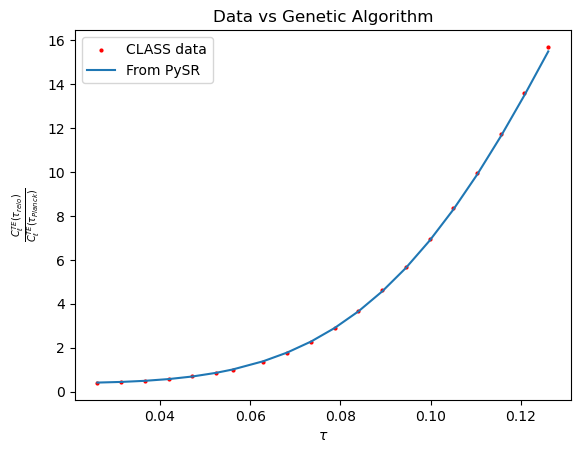

In [213]:
mod2 = model.from_file('hall_of_fame_2023-09-16_142645.495.pkl')

t = t_reio.reshape(-1,1)
ratio_tau = np.array(df[(df['ell'] == 8)]['EE/EE_planck'])
print('The accuracy of this model is', np.round(accuracy(ratio_tau,mod2.predict(t)),2))

plt.scatter(t_reio,ratio_tau, label='CLASS data', s=4, color='r')
plt.plot(t_reio,mod2.predict(t), label='From PySR')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$')
plt.title('Data vs Genetic Algorithm')
plt.legend()

In [214]:
def fg(x,y):
    f = (((18.9/x)**x)+np.e**(2*np.e**(-0.0454*x))*x)*0.195
    g = (((1.25*10**5)*y**4.15)/(((5.12*10**4)*y**5.92)+1.29))+0.384
    pr = f * g
    return pr

In [221]:
norm_ga = []

for i in range (a):
    z = np.max((ee[(i * alpha):(i + 1)*alpha]/cl['EE'][0:alpha]))*fg(ell[(i * alpha):(i + 1)*alpha],tau[(i * alpha):(i + 1)*alpha])/np.max(fg(ell[(i * alpha):(i + 1)*alpha],tau[(i * alpha):(i + 1)*alpha]))
    norm_ga.append(z)
fg_ga = np.concatenate(norm_ga)

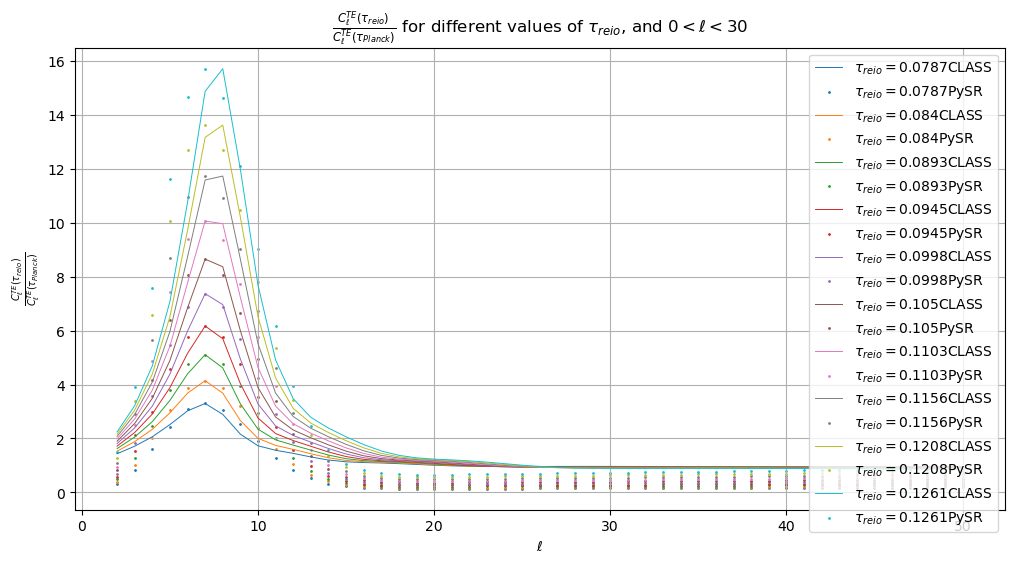

In [229]:
plt.figure(figsize=(12, 6))
norm_surf = []
for j in range (10):
    i = j + 10
    l = ell[(i * alpha):(i + 1)*alpha]
    y = (ee[(i * alpha):(i + 1)*alpha]/cl['EE'][0:alpha])
    z = fg_ga[(i * alpha):(i + 1)*alpha]
    norm_surf.append(z)
    string = r'$\tau_{reio}=$' + str(round(t_reio[i], 4)) + 'CLASS'
    string2 = r'$\tau_{reio}=$' + str(round(t_reio[i], 4)) + 'PySR'
    plt.plot(l,y, label=string, lw=0.7)
    plt.scatter(l,z, label=string2, s=1)
    plt.legend()
plt.xlabel('$\ell$')
plt.ylabel(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$')
plt.title(r'$\frac{C_{\ell}^{TE}(\tau_{reio})}{C_{\ell}^{TE}(\tau_{Planck})}$ for different values of $\tau_{reio}$, and $0<\ell<30}$')
plt.grid(True)
plt.show() 